In [14]:
%tensorflow_version 2.x
import tensorflow as tf
print("TF Version: ", tf.__version__)
device_name = tf.test.gpu_device_name()
IS_GPU = tf.test.gpu_device_name() == '/device:GPU:0'
if not IS_GPU:
  # raise SystemError('GPU device not found')
  pass
import numpy as np
np.set_printoptions(precision=3)

import os
import random
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
%matplotlib inline

!git clone https://github.com/mixuala/tf_utils.git
from tf_utils import helpers
from tf_utils.io import load, show, save

!git clone https://github.com/mixuala/fast_neural_style_pytorch.git
from fast_neural_style_pytorch import transformer, vgg, utils
import fast_neural_style_pytorch.utils as torch_utils

from fast_neural_style_pytorch.tensorflow import utils as fnstf_utils
from fast_neural_style_pytorch.tensorflow import vgg as tf_vgg
from fast_neural_style_pytorch.tensorflow import transformer as tf_transformer

!git clone https://github.com/mixuala/colab_utils.git
import colab_utils.tboard

TF Version:  2.1.0
fatal: destination path 'tf_utils' already exists and is not an empty directory.
fatal: destination path 'fast_neural_style_pytorch' already exists and is not an empty directory.
fatal: destination path 'colab_utils' already exists and is not an empty directory.


# settings

In [0]:
# GLOBAL SETTINGS
DATASET_PATH = "/content/train"
RECORD_PATH = '/content/coco2014-sq-1000.tfrecord'
LOG_PATH = "/content/logs/"
STYLE_IMAGE_PATH = "/content/mosaic.jpg"
SAVE_MODEL_PATH = "/content/checkpoint/"
SAVE_IMAGE_PATH = SAVE_MODEL_PATH

TRAIN_IMAGE_SIZE = 256
NUM_EPOCHS = 5
NUM_BATCHES = 250
BATCH_SIZE = 4 
# CONTENT_WEIGHT = 1 
# STYLE_WEIGHT = 1
TV_WEIGHT = 1e-6 
ADAM_LR = 0.001
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 36
PLOT_LOSS = 1


# download data

In [0]:
if not os.path.isfile(STYLE_IMAGE_PATH):
  !wget -O $STYLE_IMAGE_PATH https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg
  # `.tfrecord` file of 1000 sq images
  !wget -O $RECORD_PATH https://query.data.world/s/e7ny5zjv7rdklfhkg4uzaccsejm2s7


# setup

#### style image


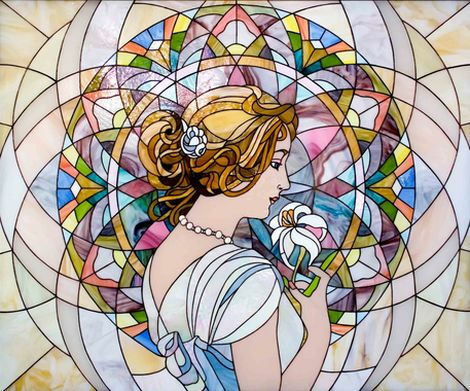
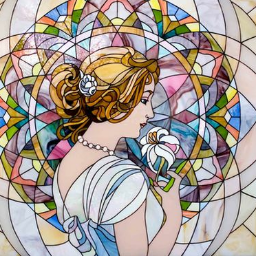

In [17]:
# style_image = load(STYLE_IMAGE_PATH)[...,:3] # tf.float32
image_string = tf.io.read_file(STYLE_IMAGE_PATH)
style_image = fnstf_utils.ImageRecordDatasetFactory.image2tensor(image_string, normalize=False)
style_image_SQ = fnstf_utils.ImageRecordDatasetFactory.random_sq_crop(style_image, size=256)
show([style_image, style_image_SQ], domain=(0,255), w=256)  


# style_image = style_image_SQ

In [0]:
def use_checkpoints_and_tboard():
  """Save checkpoints to google Drive using symbolic link """
  if os.path.isdir('/content/drive'):
    check_if_link = !ls -al /content/checkpoint
    print("saving checkpoint to google drive...")
    if check_if_link[0].find('/content/drive/')<0:
      dest = os.path.dirname(SAVE_MODEL_PATH)
      print("dest", dest)
      old = "{}_0".format(dest)
      !mv $dest $old
      !ln -s '/content/drive/My Drive/checkpoints' $dest
  # launch tensorboard
  ROOT = %pwd
  colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_PATH )

if not os.path.isdir(SAVE_MODEL_PATH): os.makedirs(SAVE_MODEL_PATH)
# use_checkpoints_and_tboard()

# Tensorflow implementation


## preflight checks

In [0]:
# # TransformerNetwork.trainable_weights
# transformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
# check = transformerNetwork_VGG.transformer
# print(check, check.trainable_weights) 
# check.build(input_shape=(None,256,256,3))
# check.summary()

In [0]:
# # see: https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
# vgg = transformerNetwork_VGG.vgg.loss_model
# vgg.build(input_shape=(None,256,256,3))
# vgg.summary()

## prepare `TFRecordDataset`

count= 1000 , size= 16667571



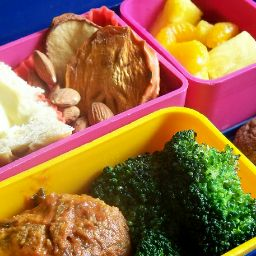
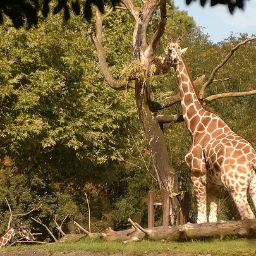
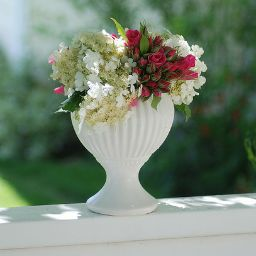
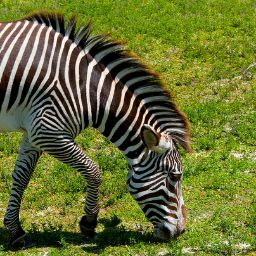

In [21]:
RecordsetHelper = fnstf_utils.ImageRecordDatasetFactory
rec_dataset = tf.data.TFRecordDataset(RECORD_PATH) # /content/coco2014-sq-1000.tfrecord
image_ds_255 = rec_dataset.map(RecordsetHelper.example_parser(image2tensor=True, normalize=False))


count = rec_dataset.reduce(0, lambda x, _: x + 1)
print("count=",count.numpy(), ", size=", os.path.getsize(RECORD_PATH))


tensor_ds_255 = image_ds_255.map(lambda d: d['image'])
show([img for img in tensor_ds_255.take(4)], w=128)

In [0]:
# losses: see also, fnstf_utils.get_SUM_mse_loss()
MSELoss = tf.keras.losses.MSE
# works for both style and content losses
def get_MEAN_mse_loss(y_true, y_pred, weights=None):
  if isinstance(y_pred, (tuple, list)):
    if weights is not None:
      assert len(weights)==len(y_pred), "weights do not match"
      losses = [ get_MEAN_mse_loss(y_true, y_pred, w) for (y_true, y_pred, w) in zip(y_true, y_pred, weights) ]
    else:
      losses = [ get_MEAN_mse_loss(y_true, y_pred, None) for (y_true, y_pred) in zip(y_true, y_pred) ]
    return tf.reduce_mean(losses)
    
  if tf.is_tensor(y_pred):
    batch_size = y_pred.shape[0]
    weights = weights or 1.
    return tf.reduce_mean(MSELoss(y_true[:batch_size], y_pred)) * weights
  assert False, "unexpected input"


## `keras.callbacks`

In [0]:
class CheckpointCallback(tf.keras.callbacks.Callback):
  """ save checkpoints on a fixed schedule
  """
  def __init__(self, model, filepath):
    super(CheckpointCallback, self).__init__()
    self.model = model
    self.checkpoint_path = filepath
    assert os.path.isdir(os.path.dirname(filepath)) , "ERROR: parent dir missing, path={}".format(filepath)

  def save_weights(self, suffix):
    _transformer = self.model.transformer if hasattr(self.model, 'transformer') else self.model
    filepath = "{}_{}.h5".format(self.checkpoint_path,suffix)
    _transformer.save_weights(filepath, save_format='h5')
    return filepath
    
  def on_batch_end(self, batch, logs=None):
    if batch>0 and batch%2000==0:
      fname = self.save_weights("step_{}".format(batch))
      print("\n>>> saving checkpoint={}\n ".format(os.path.basename(fname)) )

    # something funny happens around step 3500  
    elif batch>3200 and batch<4000 and batch%100==0:
      fname = self.save_weights("step_{}".format(batch))
      print("\n>>> saving checkpoint={}\n ".format(os.path.basename(fname)) )


  def on_epoch_end(self, epoch, logs=None):
    fname = self.save_weights("epoch_{}".format(epoch))
    print("\n>>> saving checkpoint={}\n ".format(os.path.basename(fname)) )
    return
    

# checkpoint_path = os.path.join(SAVE_MODEL_PATH, "tf_checkpoint")
# Checkpoints = CheckpointCallback(TransformerNetwork_VGG, checkpoint_path)
# Checkpoints.save_weights(270)

#### SnapshotCallback

In [0]:
class SnapshotCallback(tf.keras.callbacks.Callback):
  def __init__(self, validation_images, model=None, stacker=None, 
        log_after_batch=None, 
        save_image_path=None,
        epoch_offset=0, 
        ):
    super(SnapshotCallback, self).__init__()

    # convert validation images to batch of images
    if isinstance(validation_images, (tuple, list)):
      validation_images = tf.stack(validation_images, axis=0)
    elif isinstance(validation_images, tf.data.Dataset):
      validation_images = next(iter(validation_images))
    assert tf.is_tensor(validation_images), "ERROR: expecting a list or batch of images, got {}".format(validation_images)
    if len(validation_images.shape)==3: validation_images = validation_images[tf.newaxis, ...]
    b,h,w,c = validation_images.shape

    self.images = validation_images # batch of images
    self.cur_index = 0
    self.model = model
    self.stacker = stacker if stacker is not None else helpers.ImgStacker()
    self.offset = epoch_offset
    self.batch = 0        # step in current epoch
    self.iteration = 0  # same as opt.iterations
    self.log_after_batch=log_after_batch
    self.save_image_path=save_image_path

  def getImage(self):
    i = self.cur_index
    self.cur_index += 1
    img = self.images[i:self.cur_index]
    if self.cur_index >= self.images.shape[0]: self.cur_index = 0
    return img

  def show_latest(self):
    show( self.stacker.hstack(), w=128, domain=(0,255))
    return

  def push_latest(self):
    if self.stacker is not None:
      input_batch = self.getImage()
      _transformer = self.model.transformer if hasattr(self.model, 'transformer') else self.model
      generated_image = _transformer(input_batch)
      rgb_image = tf.squeeze(generated_image).numpy() # 255.
      rgb_clipped = rgb_image.clip(0.,255.)
      check = self.stacker.hstack( rgb_clipped, limit=10 )
      show( check, domain=None )

  def save_latest(self, count):
    if self.stacker is not None and self.save_image_path is not None:
      # save generated image history
      try:
        filepath = os.path.join(self.save_image_path , "tf_sample_{}.png".format(count))
        save( self.stacker.hstack(), filepath)
        # im=Image.fromarray(np.uint8(self.stacker.hstack()))
        # im.save(filepath)
      except:
        pass

  def on_batch_end(self, batch, logs=None):
    # on_batch_end: logs include `loss`, and optionally `acc`
    # logs = logs or {}
    first = batch==0
    self.batch = np.maximum(batch, self.batch)
    if self.log_after_batch is not None and batch % self.log_after_batch==0:
      self.push_latest()
      if logs and hasattr(logs,'loss'):
        print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
      if not first and batch % (self.log_after_batch*10):
        self.save_latest(batch)

  def on_epoch_end(self, epoch, logs=None):
    # on_epoch_end: logs include `acc` and `loss`, and optionally include `val_loss` (if validation is enabled in `fit`), and `val_acc`
    # logs = logs or {}
    # epoch is 0-based
    num_batches = self.batch
    self.iteration += num_batches
    self.batch = 0 # reset for next epoch

    overall = self.offset + self.iteration
    if self.log_after_batch is None or overall % num_batches ==0:
      self.push_latest() 
      self.save_latest(overall)


### HistoryCallback
common loss summaries between `GradientTape` and `model.fit()`

In [0]:
class HistoryCallback(tf.keras.callbacks.Callback):
  """ emulate history = model.fit() output 
  usage: 
    history = HistoryCallback()
    losses = history.history() or history.history(as_dict=True)
  """
  def __init__(self, stash=None):
    super(HistoryCallback, self).__init__()
    self._batches = None 
    self._epochs = None
    self.stash = stash
    self.FROM_MODEL_FIT = False
    self.HAS_TOTAL_LOSS = False
    self.IS_GPU = tf.test.gpu_device_name() == '/device:GPU:0'

  def on_batch_end(self, batch, logs=None, losses=None):
    if losses is None and logs is not None:
      # logs: 
      #   batch <class 'int'>
      #   size <class 'numpy.int64'>
      #   loss <class 'numpy.float32'>
      #   output_1_loss <class 'numpy.float32'>
      #   output_2_loss <class 'numpy.float32'>
      #   output_3_loss <class 'numpy.float32'>
      #   output_4_loss <class 'numpy.float32'>
      #   output_5_loss <class 'numpy.float32'>
      #   output_6_loss <class 'numpy.float32'>
      keys = [k for k in logs.keys() if k.endswith("loss")]
      losses = [logs[k] for k in keys]
      self.FROM_MODEL_FIT = 'batch' in logs and 'size' in logs

    losses = tf.expand_dims(losses, 0) 
    self._batches = losses if self._batches is None else tf.concat( [self._batches, losses], axis=0 )

    # if batch==0 and len(self._epochs)==0: 
    if batch==0 and self._epochs is None: 
      self.on_epoch_end(0)              # count batch=0 as epoch=0, but don't reset self._batches

    if self.FROM_MODEL_FIT and 'loss' in logs: # model.fit(), loss=reduce_mean(logs['loss']), but just multiple losses are for just the batch
      cumulative_batch_losses = tf.reduce_mean(self._batches[:,0]) # reduce_mean only "total_loss"
      self.HAS_TOTAL_LOSS = True
      start_from = 1 # skip logs['loss']
    else:
      cumulative_batch_losses = tf.reduce_mean(tf.reduce_sum(self._batches, axis=1)) # shape=(NUM_BATCHES,6)  
      start_from = 0

    if self.IS_GPU==True and batch%100!=0:
      return


    # log results
    # i, *lossCount = self._batches.shape
    # startFrom = start_from if lossCount[-1]>1 else 0 # skip 'loss' when multiple outputs
    most_recent_losses = tf.squeeze(self._batches[-1, ..., :])
    log_output = "\tbatch: {} >>> loss: {}, batch losses: {}".format(
        self._batches.shape[0], 
        cumulative_batch_losses.numpy(), 
        most_recent_losses.numpy() )
    if self.FROM_MODEL_FIT:
      log_output = '\n' + log_output
    print(log_output)

    return self._batches.shape[0]

  def on_epoch_end(self, epoch, logs=None):
    if self._batches is None:
      return
    """epoch losses are reduce_mean(batch_losses)"""
    cur_epoch_losses = tf.reduce_mean(self._batches, axis=0) # shape=(NUM_BATCHES,6)  
    # self._epochs.append( cur_epoch_losses.numpy() ) # list of ndarray
    cur_epoch_losses = tf.expand_dims(cur_epoch_losses, 0) 
    self._epochs = cur_epoch_losses if self._epochs is None else tf.concat( [self._epochs, cur_epoch_losses], axis=0 )

    # if len(self._epochs)==1: 
    if self._epochs.shape[0] > 1:
      # first row is for reporting only, do NOT reset self._batches
      self._batches=None

    print("epoch: {} >>> loss: {}\n".format(len(self._epochs)-1, tf.squeeze(cur_epoch_losses).numpy()) )
    return cur_epoch_losses

  def history(self, as_dict=False, prefix="output_loss"):
    # if len(self._epochs)==0:
    if self._epochs is None:
      print("History.history() returns batch losses")
      losses = self._batches # shape=(NUM_BATCHES,6)
    else:
      print("History.history() returns epoch losses")
      losses = self._epochs # shape=(NUM_EPOCHS,6)
    if not as_dict: return losses

    # format as dict
    result = {}
    rows, cols = losses.shape
    for c in range(cols):
      if self.HAS_TOTAL_LOSS:
        key_prefix = "loss" if c==0 else prefix
      else:
        key_prefix = prefix

      key = "{}_{}".format(key_prefix, c)
      result[key] = losses[:,c]
    return result


# Transformer network with VGG output



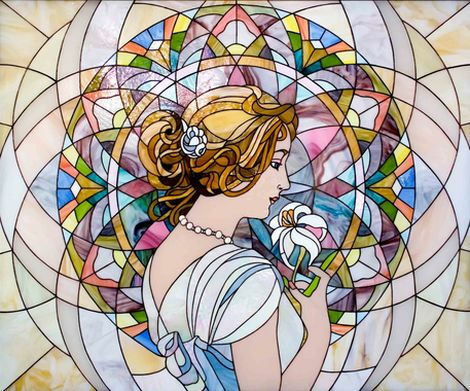

In [26]:
transformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
get_MEAN_mse_loss = fnstf_utils.get_MEAN_mse_loss
# transformerNetwork_VGG.vgg.style_image = style_image
show([style_image], labels=["style_image, shape={}".format(style_image.shape)], w=128, domain=(0.,255.) )

In [0]:
transformerNetwork_VGG2 = transformerNetwork_VGG
TARGET_STYLE_GRAM = transformerNetwork_VGG2.vgg.target_style_gram

In [32]:
# # get y_true from generator
def BATCH_xyGenerator_y_true_as_features_and_weights(tensor_ds_255, 
                                                     VGGfeatures,
                                                     feature_weights=None
                                                     ):
  """ returns generator with weights(x_train, y_true, weights)
  """

  if feature_weights is not None: print("dataset generator using FEATURE_WEIGHTS=", feature_weights)
  
  def gen():
    weights = tuple( [v] for v in feature_weights) if feature_weights else tuple( [1.] for v in range(6))
    for x_train in tensor_ds_255.batch(BATCH_SIZE):
      batch = x_train if len(x_train.shape)==4 else x_train[tf.newaxis,...]
      y_true_features = VGGfeatures.get_y_true(batch)
      yield (x_train, y_true_features, weights)

  output_types= (
      tf.float32,    
      ( 
        tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32
      ),
      (tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)
  )

  output_shapes = ( 
      (None, 256,256,3),
      (
        (None, 16, 16, 512),
        (None, 64, 64), (None, 128, 128), (None, 256, 256), (None, 512, 512), (None, 512, 512)
      ),
      (
          (1,),     (1,),(1,),(1,),(1,),(1,)
      )
  )
  return tf.data.Dataset.from_generator(
                                      generator=gen, 
                                      output_types=output_types, 
                                      output_shapes=output_shapes,
                                    )


ONES = [1.,1.,1.,1.,1.,1.,]
FEATURE_WEIGHTS = ONES
BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
    tensor_ds_255, 
    transformerNetwork_VGG2.vgg,
    feature_weights=ONES)

for x_train,y_true,weights in BATCH_xy_Dataset255_with_features.take(1):
  print(x_train.shape)
  print([(v.shape) for v in y_true])
  print(weights)
  for a,b in zip(y_true[1:], transformerNetwork_VGG2.vgg.target_style_gram):
    tf.assert_equal(a,b, "y_true target_style_gram is INCORRECT")


dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(4, 256, 256, 3)
[TensorShape([4, 16, 16, 512]), TensorShape([4, 64, 64]), TensorShape([4, 128, 128]), TensorShape([4, 256, 256]), TensorShape([4, 512, 512]), TensorShape([4, 512, 512])]
(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


# `tf.GradientTape` 


### tf.GradientTape with `TransformerNetwork_VGG()`

In [0]:
# use_checkpoints_and_tboard()

dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



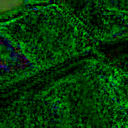

========Epoch 1/2========
epoch: 0 >>> loss: [   5085.783    3086.514  237239.17   247332.45  4207535.5       124.43 ]

	batch: 1 >>> loss: 4700404.0, batch losses: [   5085.783    3086.514  237239.17   247332.45  4207535.5       124.43 ]
	batch: 101 >>> loss: 1293628.875, batch losses: [  6727.255    334.938  29789.873  61542.766 371061.5       77.96 ]
	batch: 201 >>> loss: 812924.125, batch losses: [  5806.913    195.13   14089.463  37351.445 191925.27      72.826]
>>>> epoch=1 complete
epoch: 1 >>> loss: [  5930.837    704.166  43073.656  77217.66  573066.9       99.069]




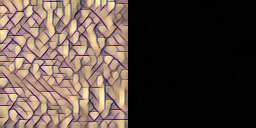

========Epoch 2/2========
	batch: 1 >>> loss: 212400.859375, batch losses: [  6298.257    185.619  12236.868  28719.676 164883.22      77.215]
	batch: 101 >>> loss: 199836.6875, batch losses: [  6843.179    163.263  10559.892  25574.146 143796.66      70.614]
	batch: 201 >>> loss: 188579.828125, batch losses: [  6089.498    138.225   9436.807  23123.977 124974.96      70.838]
>>>> epoch=2 complete
epoch: 2 >>> loss: [  5877.158    155.001  10220.913  25014.98  142256.98      68.06 ]




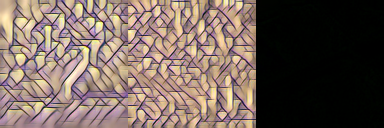

Done Training the Transformer Network!
Training Time: 83.48589420318604 seconds
========Content Loss========
[]
========Style Loss========
[]
========Total Loss========
[]


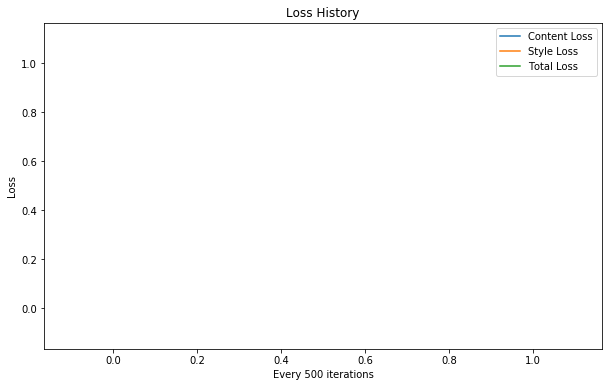

In [48]:
### tf.GradientTape:

np.random.seed(SEED)
tf.random.set_seed(SEED)
NUM_EPOCHS = 2
NUM_BATCHES = 250 if IS_GPU else 20  # =1000/BATCH_SIZE

### configure for TransformerNetwork_VGG 
TransformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
TransformerNetwork = TransformerNetwork_VGG.transformer
VGG = TransformerNetwork_VGG.vgg

ONES =                          [1.,1.,1.,1.,1.,1.,]
normalized_weights =            [   18.54,           1605.23,   25.08,    8.16,    1.28, 2330.79]
boost_style_FEATURE_WEIGHTS =   [   0.1854,          1605.23,   25.08,    8.16,    1.28, 2330.79]  # boost style loss x100
FEATURE_WEIGHTS = ONES

BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
      tensor_ds_255, 
      TransformerNetwork_VGG.vgg,
      feature_weights=FEATURE_WEIGHTS
    )
train_dataset = BATCH_xy_Dataset255_with_features.take(NUM_BATCHES) # already batched
# pre-flight
stacker = helpers.ImgStacker()
stacker.clear()
# validation_imgs = [ image for image in tensor_ds_255.take(10)]
validation_imgs = tensor_ds_255.batch(10)
Snapshot = SnapshotCallback(validation_imgs, 
                            model=TransformerNetwork_VGG, 
                            stacker=stacker, 
                            save_image_path=SAVE_IMAGE_PATH,
                            log_after_batch=None if IS_GPU else 10)
  
History = HistoryCallback()
checkpoint_path = os.path.join(SAVE_MODEL_PATH, "tf_checkpoint")
Checkpoints = CheckpointCallback(TransformerNetwork_VGG, checkpoint_path)

def train():
  # # Seeds
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # # Optimizer settings
  optimizer = tf.optimizers.Adam(learning_rate=ADAM_LR, beta_1=0.99, epsilon=1e-1)

  # # Loss trackers
  content_loss_history = []
  style_loss_history = []
  total_loss_history = []
  batch_content_loss_sum = 0.
  batch_style_loss_sum = 0.
  batch_total_loss_sum = 0.

  # # Optimization/Training Loop
  @tf.function()
  def train_step(x_train, y_true, loss_weights=None, log_freq=10):
    with tf.GradientTape() as tape:
      y_pred = TransformerNetwork_VGG(x_train)
      
      if loss_weights:
        assert len(loss_weights) == len(y_pred), "ERROR: invalid format for loss_weights, got {}".format(loss_weights)


      generated_content_features = y_pred[:1]
      generated_style_gram = y_pred[1:]

      target_content_features = y_true[:1]
      target_style_gram = TransformerNetwork_VGG.vgg.target_style_gram

      # loss_function = get_SUM_mse_loss   
      _loss_function = fnstf_utils.get_MEAN_mse_loss   # confirmed OK 

      weights = loss_weights[:1] if loss_weights else None
      content_loss = _loss_function(target_content_features, generated_content_features, weights)

      weights = loss_weights[1:] if loss_weights else None
      s_loss = _loss_function(target_style_gram, generated_style_gram, weights, reduce=False)
      # s_loss = tuple(_loss_function(x,y)*w for x,y,w in zip(target_style_gram, generated_style_gram, weights))
      total_style_loss = tf.reduce_sum(s_loss)

      # apply batch_losses to grads
      total_loss = content_loss + total_style_loss

      learning_model = TransformerNetwork_VGG.transformer

      grads = tape.gradient(total_loss, learning_model.trainable_weights)
      optimizer.apply_gradients(zip(grads, learning_model.trainable_weights))

      return (content_loss, total_style_loss, s_loss)
      # end: with tf.GradientTape()
      # end: train_step()


  Snapshot.push_latest()
  start_time = time.time()
  for epoch in range(NUM_EPOCHS):
    print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
    for batch, (x_train, y_true, weights) in enumerate(train_dataset):
      batch_no = batch+1
      step_no = epoch*NUM_BATCHES + batch_no
      batch_no = step_no # deprecate
      # x_train, y_true are VGG features
      # print("{}: batch shape={}".format(batch_no, x_train.shape))
      # Get current batch size in case of odd batch sizes
      curr_batch_size = x_train.shape[0]

      #   # Backprop and Weight Update
      (content_loss, style_loss, s_loss) = train_step(x_train, y_true, loss_weights=FEATURE_WEIGHTS ) # 255.

      batch_content_loss_sum += content_loss
      batch_style_loss_sum += style_loss
      batch_total_loss_sum += (content_loss + style_loss)

      item_losses = (content_loss,) + s_loss
      History.on_batch_end(batch, losses=item_losses ) # loss= list of floats
      Snapshot.on_batch_end(batch_no)

      # # Save Model and Print Losses
      # if (((batch_no-1)% SAVE_MODEL_EVERY == 0) or (batch_no==NUM_EPOCHS*NUM_BATCHES)):

      #   # Print Losses
      #   print("========Iteration {}/{}========".format(batch_no, NUM_EPOCHS*NUM_BATCHES))
      #   print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_no))
      #   print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_no))
      #   print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_no))
      #   print("Time elapsed:\t{} seconds".format(time.time()-start_time))

      #   # rgb_image = tf.squeeze(generated_batch[0,...]).numpy() # 255.
      #   # check = np.stack([np.amin(rgb_image, axis=(0,1)), np.average(rgb_image, axis=(0,1)), np.amax(rgb_image, axis=(0,1))], axis=1)
      #   # print( "\tImage, (min,mean,max):\t{}".format( check ) )

      #   # # rgb_batch = tf.image.convert_image_dtype(generated_batch/255., dtype=tf.uint8, saturate=True)
      #   # generated_batch = tf.clip_by_value(generated_batch, 0.,255.)
      #   # show(generated_batch, w=128, domain=(0,255))

      #   # Save loss histories
      #   content_loss_history.append((batch_content_loss_sum/batch_no).numpy())
      #   style_loss_history.append((batch_style_loss_sum/batch_no).numpy())
      #   total_loss_history.append((batch_total_loss_sum/batch_no).numpy())


    # end epoch, summarize batch_losses
    epoch_no = epoch+1
    print(">>>> epoch={} complete".format(epoch_no, time.time()-start_time))
    epoch_loss = History.on_epoch_end( epoch_no ) # close batch, return sum of batch_losses, shape=(1,6)
    # print(">>>> \tepoch={}: losses= {}".format(epoch_no, epoch_loss.numpy()))
    Snapshot.on_epoch_end(epoch)
    if epoch_no%5==0: Checkpoints.on_epoch_end(epoch_no)

    # # Save Model
    # if batch_no>1:
    #   checkpoint_path = os.path.join(SAVE_MODEL_PATH, "grad-tape_checkpoint_{}.h5".format(epoch+1))
    #   TransformerNetwork_VGG.transformer.save_weights(checkpoint_path, save_format='h5')
    #   print("Saved tf TransformerNetwork checkpoint file at {}".format(checkpoint_path))

    # # Save generated image
    # sample_image_path = os.path.join(SAVE_IMAGE_PATH, "tf_sample_{}.png".format(epoch+1))
    # im=Image.fromarray(np.uint8(stacker.hstack()))
    # im.save(sample_image_path)
    # print("Saved sample tranformed image at {}".format(sample_image_path))

  stop_time = time.time()

  # Print loss histories
  print("Done Training the Transformer Network!")
  print("Training Time: {} seconds".format(stop_time-start_time))
  print("========Content Loss========")
  print(content_loss_history) 
  print("========Style Loss========")
  print(style_loss_history) 
  print("========Total Loss========")
  print(total_loss_history) 
  # Plot Loss Histories
  if (PLOT_LOSS):
      torch_utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)

  # save generated image History
  sample_image_path = os.path.join(SAVE_IMAGE_PATH , "tf_sample_{}.png".format(NUM_EPOCHS*NUM_BATCHES))
  im=Image.fromarray(np.uint8(stacker.hstack()))
  im.save(sample_image_path)

train()


History.history() returns epoch losses
step=3, losses=[  5877.16    155.    10220.91  25014.98 142256.98     68.06]
normalized weights: [  31.24 1184.46   17.96    7.34    1.29 2697.53]


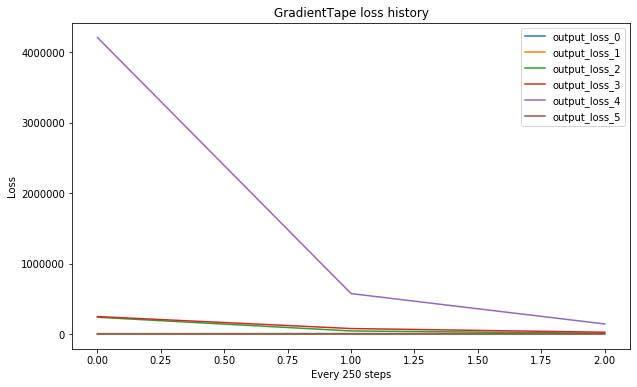


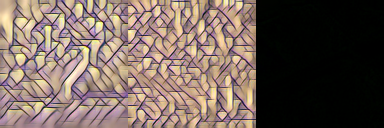

History.history() returns epoch losses
[[   5085.78    3086.51  237239.17  247332.45 4207535.5      124.43]
 [   5930.84     704.17   43073.66   77217.66  573066.9       99.07]
 [   5877.16     155.     10220.91   25014.98  142256.98      68.06]]


In [50]:
history_losses = History.history(as_dict=True) # shape=(NUM_EPOCHS, 6)
fnstf_utils.get_normalized_weights_from_loss_history(history_losses)

# plot losses
plt.figure(figsize=[10, 6])
for i,(k,v) in enumerate(history_losses.items()):
  x = [i for i in range(len(v))]
  plt.plot(x, v, label=k)

plt.legend()
plt.xlabel('Every {} steps'.format(NUM_BATCHES))
plt.ylabel('Loss')
plt.title("GradientTape loss history")
plt.show()

Snapshot.show_latest()

losses = History.history()
print(np.stack(losses, axis=0))

### Predict

In [51]:
checkpoint_path = os.path.join(SAVE_MODEL_PATH, "tf_checkpoint")
Checkpoints = CheckpointCallback(TransformerNetwork_VGG, checkpoint_path)
Checkpoints.on_epoch_end(2)


>>> saving checkpoint=tf_checkpoint_epoch_2.h5
 


style transfer, checkpoint=2:



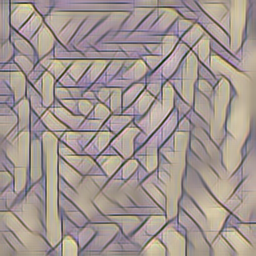
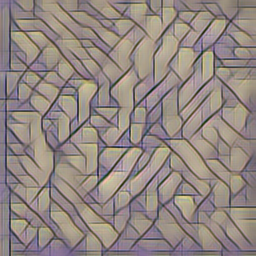
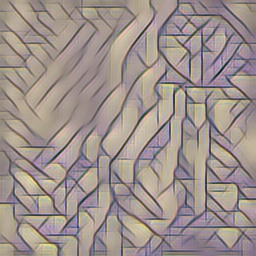
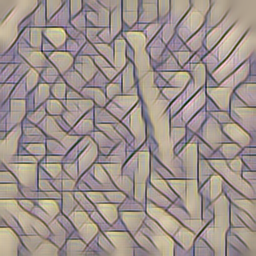


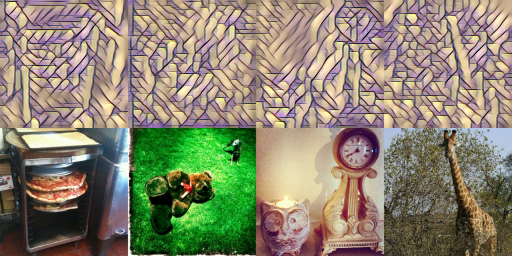

In [52]:
outputs=[]
for path in [LOG_PATH, SAVE_MODEL_PATH]:
  f = os.path.dirname(path)
  if not os.path.isdir(f): os.mkdir(path)

predict_imgs = image_ds_255.map(lambda d: d['image']).shuffle(buffer_size=100).batch(4).take(2)
for batch in predict_imgs:
  outputs.append(batch)

  CHECKPOINTS = [2] # use ascending order
  for CHECKPOINT in CHECKPOINTS:
    load_file = os.path.join(SAVE_MODEL_PATH, "tf_checkpoint_epoch_{}.h5".format(CHECKPOINT))

    # TransformerNetwork = tf_transformer.TransformerNetwork()
    TransformerNetwork.build(input_shape=(None,256,256,3))
    TransformerNetwork.load_weights(load_file)
    predictions = TransformerNetwork.predict(batch)
    predictions = tf.floor(predictions)
    if True:
      print("style transfer, checkpoint={}:".format(CHECKPOINT))
      show(predictions, domain=None, w=128)
    outputs.append(predictions)
  break


batch_stacker = helpers.ImgStacker()
batch_stacker.clear()
batch_stacker.vstack(outputs, smaller=True)
show(batch_stacker.vstack(), domain=(0,255))


# `model.fit()` with `Transformer_VGG()`


In [0]:
# use_checkpoints_and_tboard()

dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Train for 250 steps
Epoch 1/2
epoch: 0 >>> loss: [4.696e+06 5.097e+03 3.112e+03 2.359e+05 2.470e+05 4.205e+06 1.247e+02]


	batch: 1 >>> loss: 4696394.0, batch losses: [4.696e+06 5.097e+03 3.112e+03 2.359e+05 2.470e+05 4.205e+06 1.247e+02]
100/250 [===========>..................] - ETA: 33s - loss: 1732668.5031 - output_1_loss: 6279.0767 - output_2_loss: 1606.7997 - output_3_loss: 103196.5078 - output_4_loss: 157319.0000 - output_5_loss: 1464106.5000 - output_6_loss: 160.5764
	batch: 101 >>> loss: 1722147.0, batch losses: [6.700e+05 6.287e+03 1.594e+03 1.025e+05 1.566e+05 1.455e+06 1.602e+02]
200/250 [=======================>......] - ETA: 9s - loss: 1101218.5333 - output_1_loss: 6059.0420 - output_2_loss: 941.6694 - output_3_loss: 65176.1211 - output_4_loss: 111141.0391 - output_5_loss: 917777.0625 - output_6_loss: 123.8431 
	batch: 201 >>> loss: 1097588.25, batch losses: [3.716e+05 6.057e+03 9.382e+02 6.496e+04 1


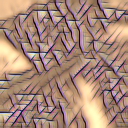

epoch: 1 >>> loss: [9.445e+05 6.060e+03 1.670e+03 1.067e+05 1.529e+05 1.575e+06 1.475e+02]

250/250 [==============================] - 48s 192ms/step - loss: 944549.4117 - output_1_loss: 6031.2778 - output_2_loss: 788.7804 - output_3_loss: 55706.0781 - output_4_loss: 97665.0469 - output_5_loss: 784243.3750 - output_6_loss: 115.0180
Epoch 2/2

	batch: 1 >>> loss: 286727.34375, batch losses: [2.867e+05 6.341e+03 2.213e+02 1.816e+04 3.597e+04 2.259e+05 8.128e+01]
100/250 [===========>..................] - ETA: 25s - loss: 262829.6613 - output_1_loss: 5783.5020 - output_2_loss: 162.0011 - output_3_loss: 14537.3379 - output_4_loss: 36560.8984 - output_5_loss: 205709.5781 - output_6_loss: 76.2850
	batch: 101 >>> loss: 262734.65625, batch losses: [2.532e+05 5.795e+03 1.615e+02 1.451e+04 3.653e+04 2.057e+05 7.629e+01]
200/250 [=======================>......] - ETA: 8s - loss: 245080.0914 - output_1_loss: 5842.6494 - output_2_loss: 147.7092 - output_3_loss: 12694.3027 - output_4_loss: 32943.121


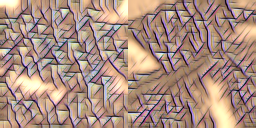

epoch: 2 >>> loss: [2.359e+05 5.802e+03 1.604e+02 1.424e+04 3.558e+04 2.032e+05 7.610e+01]

250/250 [==============================] - 43s 171ms/step - loss: 235945.0199 - output_1_loss: 5870.3936 - output_2_loss: 141.9498 - output_3_loss: 12088.4648 - output_4_loss: 31740.9980 - output_5_loss: 186029.1875 - output_6_loss: 74.0358



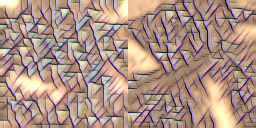

In [36]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

# # Optimizer settings
optimizer = tf.optimizers.Adam(learning_rate=ADAM_LR, beta_1=0.99, epsilon=1e-1)


### same as tf.GradientTape:
np.random.seed(SEED)
tf.random.set_seed(SEED)
NUM_EPOCHS = 2
NUM_BATCHES = 250 if IS_GPU else 20  # =1000/BATCH_SIZE
TransformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
TransformerNetwork = TransformerNetwork_VGG.transformer
VGG = TransformerNetwork_VGG.vgg
ONES =                          [1.,1.,1.,1.,1.,1.,]
normalized_weights =            [   18.54,           1605.23,   25.08,    8.16,    1.28, 2330.79]
boost_style_FEATURE_WEIGHTS =   [   0.1854,          1605.23,   25.08,    8.16,    1.28, 2330.79]  # boost style loss x100
FEATURE_WEIGHTS = ONES
BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
      tensor_ds_255, 
      TransformerNetwork_VGG.vgg,
      feature_weights=FEATURE_WEIGHTS
    )
train_dataset = BATCH_xy_Dataset255_with_features.take(NUM_BATCHES)
stacker = helpers.ImgStacker()
stacker.clear()
validation_imgs = [ image for image in tensor_ds_255.take(10)]
Snapshot = SnapshotCallback(validation_imgs, 
                            model=TransformerNetwork_VGG, 
                            stacker=stacker, 
                            save_image_path=SAVE_IMAGE_PATH,
                            log_after_batch=None if IS_GPU else 10)

History = HistoryCallback()
checkpoint_path = os.path.join(SAVE_MODEL_PATH, "std-training_checkpoint")
Checkpoints = CheckpointCallback(TransformerNetwork_VGG, checkpoint_path)


TransformerNetwork_VGG.compile(
  optimizer=optimizer,
  loss=get_MEAN_mse_loss,
)


history = TransformerNetwork_VGG.fit(
  x=train_dataset.repeat(NUM_EPOCHS),
  epochs=NUM_EPOCHS,
  steps_per_epoch=NUM_BATCHES,
  # callbacks=callbacks,
  callbacks=[Snapshot, History]
)

Snapshot.show_latest()


History.history() returns epoch losses


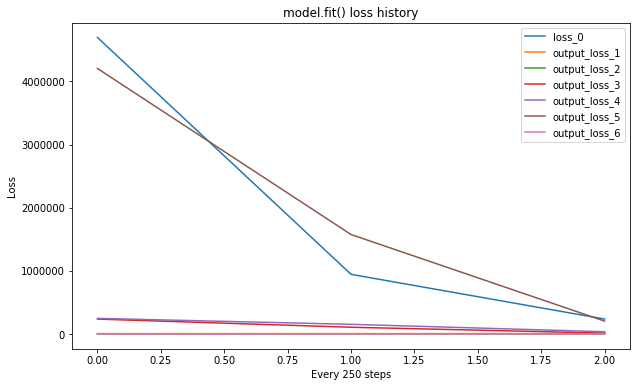


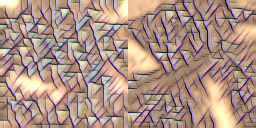

History.history() returns epoch losses
[[4.696e+06 5.097e+03 3.112e+03 2.359e+05 2.470e+05 4.205e+06 1.247e+02]
 [9.445e+05 6.060e+03 1.670e+03 1.067e+05 1.529e+05 1.575e+06 1.475e+02]
 [2.359e+05 5.802e+03 1.604e+02 1.424e+04 3.558e+04 2.032e+05 7.610e+01]]


In [37]:
# plot losses
# history_losses = history.history # from model.fit()
history_losses = History.history(as_dict=True) # shape=(NUM_EPOCHS, 6)

plt.figure(figsize=[10, 6])
for i,(k,v) in enumerate(history_losses.items()):
  x = [i for i in range(len(v))]
  plt.plot(x, v, label=k)

plt.legend()
plt.xlabel('Every {} steps'.format(NUM_BATCHES))
plt.ylabel('Loss')
plt.title("model.fit() loss history")
plt.show()

show(Snapshot.stacker.hstack(), domain=(0,255))

losses = History.history()
print(np.stack(losses, axis=0))

In [54]:

history0 = history
history1 = History.history(as_dict=True)
def get_normalized_weights_from_loss_history(history, step=-1):
  """ get normalized loss weights from a training run with no loss weights
    history = model.fit() with no loss weights
  """
  if hasattr(history, 'history'): history = history.history
  assert isinstance(history, dict), "ERROR: expecting history.history as dict of losses"

  losses = np.asarray([v for k,v in history.items()])
  step_losses = losses[-6:,-1]          # ignore total loss if present
  total_loss = np.sum(step_losses)
  loss_weights = total_loss/step_losses
  np.set_printoptions(precision=2, suppress=True) # don't use scientific notation
  print("step={}, losses={}".format(losses.shape[1],  step_losses))
  print("normalized weights:", loss_weights)
  return loss_weights

print("\nhistory: model.fit()")
get_normalized_weights_from_loss_history(history0)
print("\nhistory: History.history()")
get_normalized_weights_from_loss_history(history1)


History.history() returns epoch losses

history: model.fit()
step=5, losses=[[ 6121.91    54.94  5042.3  16392.79 93731.4     52.71]]
normalized weights: [[  19.83 2209.59   24.08    7.41    1.3  2303.04]]

history: History.history()
step=3, losses=[  5877.16    155.    10220.91  25014.98 142256.98     68.06]
normalized weights: [  31.24 1184.46   17.96    7.34    1.29 2697.53]


array([  31.24, 1184.46,   17.96,    7.34,    1.29, 2697.53],
      dtype=float32)

# `model.fit()` with `Transformer.transformer`

In [0]:
class PerceptualLosses_Loss2(tf.losses.Loss):
  name="PerceptualLosses_Loss"
  reduction=tf.keras.losses.Reduction.NONE

  def __init__(self, loss_network, target_style_gram, loss_weights=None):
    super(PerceptualLosses_Loss2, self).__init__( name=self.name, reduction=self.reduction )
    self.target_style_gram = target_style_gram # repeated in y_true
    self.VGG = loss_network

  def call(self, y_true, y_pred):

    generated_batch = y_pred
    generated_content_features, generated_style_features = self.VGG( generated_batch, preprocess=True )
    generated_style_gram = [ fnstf_utils.gram(value)  for value in generated_style_features ]  # list

    # using: model.fit( x=xx_Dataset, )
    x_train = y_true
    target_content_features, _ = self.VGG(x_train, preprocess=True )

    # Content Loss
    # MSELoss = tf.keras.losses.MSE
    content_loss = fnstf_utils.get_SUM_mse_loss(target_content_features, generated_content_features)
    content_loss *= 1.
    


    # # Style Loss sum(reduce_mean())
    style_loss = fnstf_utils.get_SUM_mse_loss(self.target_style_gram, generated_style_gram)
    style_loss *= 1.

    # # Style Loss sum(reduce_mean())
    # Reduction.None: model.fit() SummaryWriter will reduce to total_loss value, history = model.fit() keep 6 losses
    # Reduction.AUTO: model.fit() history AND SummaryWriter will reduce to total_loss value
    s_loss = fnstf_utils.get_SUM_mse_loss(self.target_style_gram, generated_style_gram, reduce=False)
    return (content_loss,) + s_loss  # tuple

    # total_loss = content_loss + style_loss
    # return total_loss
    # # return (content_loss, style_loss, total_loss)    

In [0]:
# loss function
CONTENT_WEIGHT = 1.
STYLE_WEIGHT = 1.


class PerceptualLosses_Loss1(tf.losses.Loss):
  name="PerceptualLosses_Loss"
  reduction=tf.keras.losses.Reduction.NONE

  def __init__(self, loss_network, target_style_gram, loss_weights=None):
    super(PerceptualLosses_Loss1, self).__init__( name=self.name, reduction=self.reduction )
    self.target_style_gram = target_style_gram # repeated in y_true
    self.VGG = loss_network

  def call(self, y_true, y_pred):

    generated_batch = y_pred
    generated_content_features, generated_style_features = self.VGG( generated_batch, preprocess=True )
    generated_style_gram = [ fnstf_utils.gram(value)  for value in generated_style_features ]  # list

    # using: model.fit( x=xx_Dataset, )
    x_train = y_true
    target_content_features, _ = self.VGG(x_train, preprocess=True )

    # Content Loss
    # MSELoss = tf.keras.losses.MSE
    content_loss = fnstf_utils.get_content_loss(target_content_features, generated_content_features)
    content_loss *= CONTENT_WEIGHT
    
    # # Style Loss
    s_loss = fnstf_utils.get_SUM_mse_loss(self.target_style_gram, generated_style_gram, reduce=False)
    return (content_loss,) + s_loss  # tuple




    style_loss = fnstf_utils.get_style_loss(self.target_style_gram, generated_style_gram)
    style_loss *= STYLE_WEIGHT
    return (content_loss, style_loss, total_loss)




    total_loss = content_loss + style_loss
    return total_loss
    

In [0]:
def xxGenerator255(tensor_ds_255, limit=None):
  """ returns (x_train, y_true) = (batch_image, batch_image)
  images scaled to domain=(0.,255.)
  """
  def gen():
    for image in tensor_ds_255:
      yield (image, image)
  return gen

xx_Dataset255 = tf.data.Dataset.from_generator(
  generator=xxGenerator255(tensor_ds_255),
  output_types=(tf.float32, tf.float32),
  output_shapes=(
    (256,256,3), (256,256,3),
  ),
)

### train

Train for 250 steps
Epoch 1/5
epoch: 0 >>> loss: [   5096.58    3111.91  235863.5   247004.1  4205193.5      124.69]


	batch: 1 >>> loss: 782732.3125, batch losses: [   5096.58    3111.91  235863.5   247004.1  4205193.5      124.69]
100/250 [===========>..................] - ETA: 30s - loss: 288488.6875
	batch: 101 >>> loss: 286776.59375, batch losses: [  7014.42    308.55  36642.82  81581.07 567767.7     114.68]
200/250 [=======================>......] - ETA: 9s - loss: 184912.8750
	batch: 201 >>> loss: 184280.359375, batch losses: [  5810.9     214.38  21857.66  46756.42 271897.34     88.32]
249/250 [============================>.] - ETA: 0s - loss: 159541.8125


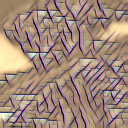

epoch: 1 >>> loss: [  6037.53    791.54  56386.89  98723.86 792685.75    115.63]

250/250 [==============================] - 44s 178ms/step - loss: 159123.5156
Epoch 2/5

	batch: 1 >>> loss: 48320.96484375, batch losses: [  6133.7     199.85  15667.49  40735.3  227116.56     72.88]
100/250 [===========>..................] - ETA: 24s - loss: 46205.5312
	batch: 101 >>> loss: 46214.39453125, batch losses: [  6963.55    105.29  14214.82  41028.95 220211.       81.14]
200/250 [=======================>......] - ETA: 8s - loss: 42637.5312
	batch: 201 >>> loss: 42597.703125, batch losses: [  6048.62    105.26   9546.96  26359.21 165644.95     75.93]
249/250 [============================>.] - ETA: 0s - loss: 40865.9141


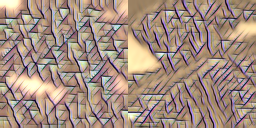

epoch: 2 >>> loss: [  5869.8     145.82  12645.65  32793.58 193513.2      75.09]

250/250 [==============================] - 40s 161ms/step - loss: 40840.5273
Epoch 3/5

	batch: 1 >>> loss: 32852.3046875, batch losses: [  6394.3     114.59  10009.15  25573.93 154947.89     73.96]
100/250 [===========>..................] - ETA: 24s - loss: 30747.3457
	batch: 101 >>> loss: 30750.091796875, batch losses: [  7042.12    103.79   7846.39  23613.08 147467.33     72.29]
200/250 [=======================>......] - ETA: 8s - loss: 29339.4355
	batch: 201 >>> loss: 29322.599609375, batch losses: [  6163.53     78.84   6828.94  20122.68 122471.42     68.53]
249/250 [============================>.] - ETA: 0s - loss: 28861.8496


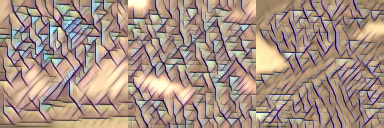

epoch: 3 >>> loss: [  5980.47     97.81   7803.59  23046.94 136153.02     69.57]

250/250 [==============================] - 40s 161ms/step - loss: 28858.5684
Epoch 4/5

	batch: 1 >>> loss: 25154.751953125, batch losses: [  6380.46     90.01   6897.59  20117.29 117378.88     64.29]
100/250 [===========>..................] - ETA: 24s - loss: 25640.1582
	batch: 101 >>> loss: 25644.958984375, batch losses: [  7231.58     79.21   6770.65  20797.97 121807.3      65.55]
200/250 [=======================>......] - ETA: 8s - loss: 24649.1562
	batch: 201 >>> loss: 24634.044921875, batch losses: [ 6135.17    62.61  5914.   17718.12 99781.48    55.84]
249/250 [============================>.] - ETA: 0s - loss: 24033.7656


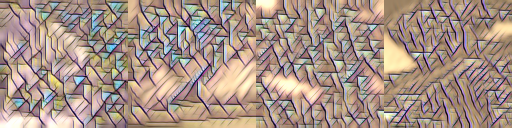

epoch: 4 >>> loss: [  6041.56     71.     6289.28  19125.86 112566.85     61.16]

250/250 [==============================] - 40s 161ms/step - loss: 24025.9512
Epoch 5/5

	batch: 1 >>> loss: 21114.396484375, batch losses: [ 6450.12    58.15  5595.04 17202.77 97326.82    53.47]
100/250 [===========>..................] - ETA: 24s - loss: 20995.9590
	batch: 101 >>> loss: 20992.01171875, batch losses: [ 7171.      55.01  5438.99 16728.64 94138.5     54.98]
200/250 [=======================>......] - ETA: 8s - loss: 20420.5938
	batch: 201 >>> loss: 20411.560546875, batch losses: [ 6374.82    40.29  4906.4  15690.74 84574.59    49.38]
249/250 [============================>.] - ETA: 0s - loss: 20232.9883


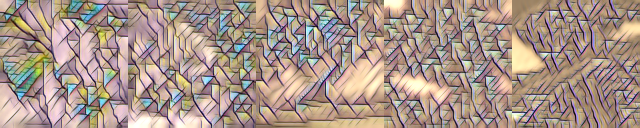

epoch: 5 >>> loss: [ 6121.91    54.94  5042.3  16392.79 93731.37    52.71]

250/250 [==============================] - 40s 161ms/step - loss: 20232.6758



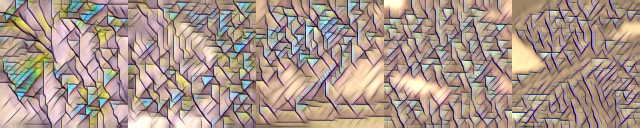

In [42]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

# # Optimizer settings
optimizer = tf.optimizers.Adam(learning_rate=ADAM_LR, beta_1=0.99, epsilon=1e-1)


### same as tf.GradientTape:
np.random.seed(SEED)
tf.random.set_seed(SEED)
NUM_EPOCHS = 5
NUM_BATCHES = 250 if IS_GPU else 20  # =1000/BATCH_SIZE
TransformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
# TransformerNetwork_VGG = TransformerNetwork_VGG2(style_image)
TransformerNetwork = TransformerNetwork_VGG.transformer
VGG = TransformerNetwork_VGG.vgg.loss_model
train_dataset = xx_Dataset255.batch(BATCH_SIZE).take(NUM_BATCHES)

ONES =                          [1.,1.,1.,1.,1.,1.,]
normalized_weights =            [   18.54,           1605.23,   25.08,    8.16,    1.28, 2330.79]
boost_style_FEATURE_WEIGHTS =   [   0.1854,          1605.23,   25.08,    8.16,    1.28, 2330.79]  # boost style loss x100
FEATURE_WEIGHTS = ONES

stacker = helpers.ImgStacker()
stacker.clear()
validation_imgs = [ image for image in tensor_ds_255.take(10)]
Snapshot = SnapshotCallback(validation_imgs, 
                            model=TransformerNetwork, 
                            stacker=stacker, 
                            save_image_path=SAVE_IMAGE_PATH,
                            log_after_batch=None if IS_GPU else 10)

History = HistoryCallback()
# checkpoint_path = os.path.join(SAVE_MODEL_PATH, "std-training_checkpoint")
# Checkpoints = CheckpointCallback(TransformerNetwork, checkpoint_path)


TransformerNetwork.compile(
  optimizer=optimizer,
  # loss=get_MEAN_mse_loss,
  loss=PerceptualLosses_Loss2(VGG, TransformerNetwork_VGG.vgg.target_style_gram, FEATURE_WEIGHTS),
)


history = TransformerNetwork.fit(
  x=train_dataset.repeat(NUM_EPOCHS),
  epochs=NUM_EPOCHS,
  steps_per_epoch=NUM_BATCHES,
  callbacks=[Snapshot, History]
)

Snapshot.show_latest()


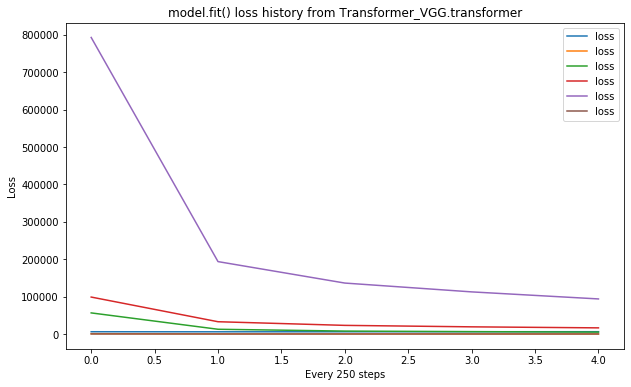


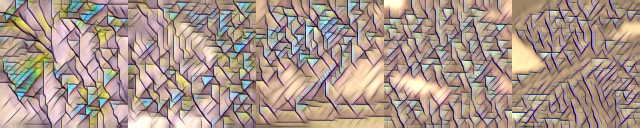

History.history() returns epoch losses
[[[   5096.581    3111.906  235863.5    247004.1   4205193.5
       124.69 ]]

 [[   6037.527     791.541   56386.887   98723.86   792685.75
       115.633]]

 [[   5869.8       145.824   12645.653   32793.582  193513.2
        75.086]]

 [[   5980.47       97.812    7803.586   23046.938  136153.02
        69.569]]

 [[   6041.56       70.998    6289.284   19125.863  112566.85
        61.16 ]]

 [[   6121.911      54.94     5042.299   16392.793   93731.37
        52.711]]]


In [43]:
# plot losses
history_losses = history.history # from model.fit()
# history_losses = History.history(as_dict=True) # shape=(NUM_EPOCHS, 6)

import matplotlib.pyplot as plt

plt.figure(figsize=[10, 6])
for i,(k,v) in enumerate(history_losses.items()):
  x = [i for i in range(len(v))]
  plt.plot(x, v, label=k)


plt.legend()
plt.xlabel('Every {} steps'.format(NUM_BATCHES))
plt.ylabel('Loss')
plt.title("model.fit() loss history from Transformer_VGG.transformer")
plt.show()


show(Snapshot.stacker.hstack(), domain=(0,255))

losses = History.history().numpy()
np.set_printoptions(precision=3,suppress=True)
print(losses)

# Unit Tests

In [34]:
class TransformerNetwork_VGG_ONES(tf.keras.Model):

  """TransformerNetwork_VGG that returns outputs as tf.ones()"""
  def __init__(self, style_image):
    super(TransformerNetwork_VGG_ONES, self).__init__()

    TransformerNetwork = tf_transformer.TransformerNetwork()
    TransformerNetwork.trainable = True
    style_model = tf_vgg.get_layers("vgg19")
    VGG = tf_vgg.vgg_layers19( style_model['content_layers'], style_model['style_layers'] )

    target_style_gram = TransformerNetwork_VGG_ONES._get_target_style_gram_from_image(style_image, style_model)
    nonzero = [tf.math.add(v,1.0) for v in target_style_gram]
    ones = [tf.math.divide_no_nan(v,v) for v in nonzero]
    vGGfeatures = VGG_Features(VGG, target_style_gram=tuple(ones))
    
    self.transformer = TransformerNetwork
    self.vgg = vGGfeatures

  def call(self, inputs):
    x = inputs
    x = self.transformer(x)
    # output_shapes = [(BATCH_SIZE, 16, 16, 512),  (BATCH_SIZE, 64, 64), (BATCH_SIZE, 128, 128), (BATCH_SIZE, 256, 256), (BATCH_SIZE, 512, 512), (BATCH_SIZE, 512, 512)]
    features = self.vgg(x)
    nonzero = [tf.math.add(v,1.0) for v in features]
    ones = [tf.math.divide_no_nan(v,v) for v in nonzero]
    return tuple(ones)

  @staticmethod
  def _get_target_style_gram_from_image(style_image, style_model):
    """"use when style_image.shape != (256,256,3)"""
    VGG_Target = tf_vgg.vgg_layers19( style_model['content_layers'], style_model['style_layers'], input_shape=None )
    if isinstance(style_image,str):
      image_string = tf.io.read_file(style_image)
      style_image = fnstf_utils.ImageRecordDatasetFactory.image2tensor(image_string, normalize=False)
    target_style_gram = VGG_Features.get_style_gram(VGG_Target, style_image)
    show([style_image], labels=["style_image, shape={}".format(style_image.shape)], w=128, domain=(0.,255.) )
    return target_style_gram



# ### unit tests
class UNIT_TEST():
  # static 
  TransformerNetwork_VGG_ONES = TransformerNetwork_VGG_ONES

  @staticmethod
  def inspect_vgg_features(features):
    """ features: features = VGG(generated_batch)"""
    assert isinstance(features, (tuple, dict)), "expecting tuple or dict got {}".format(type(features))
    if isinstance(features, tuple):
      for i, k in enumerate(features):
        if tf.is_tensor(k): print(i," >", k.shape)
        elif isinstance(k, (tuple, list)):
          _ = [ print(i,j," >>", v.shape) for j,v in enumerate(k)]
    else:
      for k in features:
        if tf.is_tensor(features[k]): print(k," >", features[k].shape)
        elif isinstance(features[k], (tuple, list)):
          _ = [ print(k," >>", v.shape) for v in features[k]]    

  @staticmethod
  def inpsect_model_losses(y_true, y_pred):
    """ check loss caclulations and loss weights"""
    print("y_pred: ")
    UNIT_TEST.inspect_vgg_features(y_pred)
    print("y_true: ")
    UNIT_TEST.inspect_vgg_features(y_true)

    if isinstance(y_pred, (tuple, list)):
      check1 = _content_loss_WEIGHTED(y_true[0], y_pred[0])
      check2 = _style_loss_WEIGHTED(y_true[:1], y_pred[:1])
      print("weighted losses", check1.numpy(), check2.numpy())

      check3 = utils.get_SUM_mse_loss(y_true[0], y_pred[0])
      check4 = utils.get_SUM_mse_loss(y_true[:1], y_pred[:1])
      print( "weights: ", CONTENT_WEIGHT, STYLE_WEIGHT)
      print("losses * weights", check3.numpy()*CONTENT_WEIGHT, check4.numpy()*STYLE_WEIGHT)


    if isinstance(y_pred, dict):
      check1 = _content_loss_WEIGHTED(y_true['content'], y_pred['content'])
      check2 = _style_loss_WEIGHTED(y_true['style'], y_pred['style'])
      print("weighted losses", check1.numpy(), check2.numpy())

      check3 = utils.get_SUM_mse_loss(y_true['content'], y_pred['content'])
      check4 = utils.get_SUM_mse_loss(y_true['style'], y_pred['style'])
      print( "weights: ", CONTENT_WEIGHT, STYLE_WEIGHT)
      print("losses * weights", check3.numpy()*CONTENT_WEIGHT, check4.numpy()*STYLE_WEIGHT)

    assert check2==check4*STYLE_WEIGHT, "style losses failed"
    assert check1==check3*CONTENT_WEIGHT, "content losses failed"


    @staticmethod
    def batch_generator_with_model_losses( transformer_vgg , BATCH_xy_Dataset255_with_TWOS):
      print("BATCH_dataset")

      # for x,y,weights in BATCH_xy_Dataset255_with_features.take(1):
      for x,y,weights in BATCH_xy_Dataset255_with_TWOS.take(1):

        print("FEATURE_WEIGHTS=", [tf.squeeze(v).numpy() for v in weights])
        # show(x, domain=None, w=128)
        # generated = TransformerNetwork(x)
        # show(generated, domain=None, w=128)

        features =  transformer_vgg(x)    

        # print("features")
        # UNIT_TEST_inspect_vgg_features(features)
        # print("y_true")
        # UNIT_TEST_inspect_vgg_features(y)

        if isinstance(features, (tuple, list)):

          print("\nFEATURE_WEIGHTS:",[v[0].numpy() for v in weights])
          print()

          check7 = utils.get_MEAN_mse_loss(y[0], features[0], weights[0]) 
          check8 = utils.get_MEAN_mse_loss(y[1:], features[1:], weights[1:])
          print("get_MEAN_mse_loss with FEATURE_WEIGHTS", check7.numpy(), check8.numpy())
          print()
          
          check5 = utils.get_SUM_mse_loss(y[0], features[0], weights[0]) 
          check6 = utils.get_SUM_mse_loss(y[1:], features[1:], weights[1:])
          print("get_SUM_mse_loss with FEATURE_WEIGHTS", check5.numpy(), check6.numpy())
          print()



        else:
          assert False, "features is probably a dict"


  @staticmethod
  def BATCH_xyGenerator_y_true_as_TWOS_and_weights(tensor_ds_255, 
                                                     VGGfeatures,
                                                     feature_weights=None
                                                     ):
    """ returns generator with weights(x_train, y_true, weights)
    """

    if feature_weights is not None: print("dataset generator using FEATURE_WEIGHTS=", feature_weights)
    
    def gen():
      weights = tuple( [v] for v in feature_weights) if feature_weights else tuple( [1.] for v in range(6))
      for x_train in tensor_ds_255.batch(BATCH_SIZE):
        batch = x_train if len(x_train.shape)==4 else x_train[tf.newaxis,...]

        # # # return as tuple( tensor, tuple) or tuple( tensor, ...)
        y_true_features = VGGfeatures(batch)
        if isinstance(y_true_features, (tuple, list)):
          if len(y_true_features)==2:
            # must FLATTEN to tuple( tensor, ...)
            content, style = y_true_features
            y_true_features = tuple([content] + list(style))
          else:
            pass # FLAT tuple(tensor x6) OK

        # ones
        nonzero = [tf.math.add(v,1.0) for v in y_true_features]
        ones = [tf.math.divide_no_nan(v,v) for v in nonzero]
        twos = [ v*2. for v in ones ]
        yield (x_train, tuple(twos), weights) 

    output_types= (
        tf.float32,    
        ( 
          tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32
        ),
        (tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)
    )

    output_shapes = ( 
        (None, 256,256,3),
        (
          (None, 16, 16, 512),
          (None, 64, 64), (None, 128, 128), (None, 256, 256), (None, 512, 512), (None, 512, 512)
        ),
        (
            (1,),     (1,),(1,),(1,),(1,),(1,)
        )
    )
    return tf.data.Dataset.from_generator(
                                        generator=gen, 
                                        output_types=output_types, 
                                        output_shapes=output_shapes,
                                      )


  @staticmethod
  def check_mean_loss():
    # [OK] get_MEAN_mse_loss() gives correct loss value of FEATURE_WEIGHTS
    ONES = [1.,1.,1.,1.,1.,1.,]
    SEQ = [1.,2.,3.,4.,5.,6.,]
    WEIGHTS = SEQ
    transformerNetwork_VGG_ONES = UNIT_TEST.TransformerNetwork_VGG_ONES(style_image)
    BATCH_xy_Dataset255_with_TWOS = UNIT_TEST.BATCH_xyGenerator_y_true_as_TWOS_and_weights(
        tensor_ds_255, 
        transformerNetwork_VGG_ONES.vgg,
        feature_weights=WEIGHTS)
    train_dataset = BATCH_xy_Dataset255_with_TWOS.take(BATCH_SIZE * NUM_BATCHES)
    # force loss = 1.    
    for x,y,w in train_dataset.take(1):
      y_pred = transformerNetwork_VGG_ONES(x)
      loss = [ fnstf_utils.get_MEAN_mse_loss(a,b, WEIGHTS[i]).numpy() for i,(a,b) in enumerate(zip(y,y_pred)) ] 
      # _ = [print( v[0,14:15,14, ...].numpy()) for v in y_pred]
      print("loss=", loss )
      assert loss==WEIGHTS
      print("[OK]: check_mean_loss()\n")


  @staticmethod
  def check_multiple_output_loss_handling():
    ONES = [1.,1.,1.,1.,1.,1.,]
    SEQ = [1.,2.,3.,4.,5.,6.,]
    FEATURE_WEIGHTS = SEQ
    TransformerNetwork_VGG = UNIT_TEST.TransformerNetwork_VGG_ONES(style_image)
    BATCH_xy_Dataset255_with_features = UNIT_TEST.BATCH_xyGenerator_y_true_as_TWOS_and_weights(
          tensor_ds_255, 
          TransformerNetwork_VGG.vgg,
          feature_weights=FEATURE_WEIGHTS
        )
    train_dataset = BATCH_xy_Dataset255_with_features.take(BATCH_SIZE * NUM_BATCHES)
    # for x,y,w in BATCH_xy_Dataset255_with_features.take(1):
    #   print("check", [v[0].numpy() for v in w])


    def get_MEAN_mse_loss_TEST(y_true, y_pred):
      # CONFIRMED, TESTED OK
      # generator returns (x,y,w)
      # losses fed individually, without weights. 
      #     loss = [loss(x,y)*w, for x,y,w in zip(y_true, y_pred, weights)]
      assert not isinstance(y_pred, (tuple, list)), "expecting a tensor NOT a tuple"
      tf.print( "lossFn shapes:", y_true.shape, y_pred.shape) 
      loss = fnstf_utils.get_MEAN_mse_loss(y_true, y_pred)
      tf.assert_equal(loss , 1., 'ERROR: expectings TWOS - ONES, loss==1., got {}'.format(loss) )
      return loss
  

    TransformerNetwork_VGG.compile(
      loss=get_MEAN_mse_loss_TEST,
    )
    history = TransformerNetwork_VGG.fit(
      x=train_dataset.repeat(NUM_EPOCHS),
      epochs=1,
      steps_per_epoch=1,
    )
    for i,(k,v) in enumerate(history.history.items()):
      check = [ print(k,v[0]) ]
      if k.startswith("output_"): # skip total loss
        assert v[0] == FEATURE_WEIGHTS[i-1], "ERROR: expecting loss == FEATURE_WEIGHT, got {}, {}".format(v[0],FEATURE_WEIGHTS[i-1])
    print("[OK]: check_multiple_output_loss_handling()\n")


  ###
  ### new
  ###
  @staticmethod
  def check_y_true_target_style_gram():
    TransformerNetwork_VGG = transformerNetwork_VGG
    BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
      tensor_ds_255, 
      TransformerNetwork_VGG.vgg,
      feature_weights=ONES)

    for x_train,y_true,weights in BATCH_xy_Dataset255_with_features.take(1):
      print(x_train.shape)
      print([(v.shape) for v in y_true])
      print([v.numpy() for v in weights])
      for a,b in zip(y_true[1:], TransformerNetwork_VGG.vgg.target_style_gram):
        tf.assert_equal(a,b, "y_true target_style_gram is INCORRECT")
      print("[OK]: check_y_true_target_style_gram()\n")

  @staticmethod
  def run():
    # UNIT_TEST.check_mean_loss()
    # UNIT_TEST.check_multiple_output_loss_handling()
    UNIT_TEST.check_y_true_target_style_gram()


UNIT_TEST.run()

dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(4, 256, 256, 3)
[TensorShape([4, 16, 16, 512]), TensorShape([4, 64, 64]), TensorShape([4, 128, 128]), TensorShape([4, 256, 256]), TensorShape([4, 512, 512]), TensorShape([4, 512, 512])]
[array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32)]
[OK]: check_y_true_target_style_gram()

